# ALeRCE  starter notebook

```Authors: Guillermo Cabrera-Vives, Daniel Moreno, Alejandra Arancibia, Last updated: 20230803```

ALeRCE starter notebook for using the features calculated by ALeRCE.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, AJ, 161, 242](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, AJ, 162, 231](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://arxiv.org/abs/2008.03311)

Note that this notebook uses the latest ALeRCE client and API, which can be installed with `pip install alerce`

## Table of contents:
* [Required libraries](#Required-libraries)
* [Accessing ALeRCE Data](#Accessing-ALeRCE-Data)
    * [Using the ALeRCE client](#Using-the-ALeRCE-client)
    * [Plotting a light-curve](#Plotting-a-light-curve)
    * [Query the ALeRCE DB for features](#Query-the-ALeRCE-DB-for-features)
* [Using the features release](#Using-the-features-release)
    * [Load features release data](#Load-features-release-data)
* [Similarity search](#Similarity-search)
    * [Visualizing K nearest neighbours](#Visualizing-K-nearest-neighbours)
  

## Required libraries

In [18]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import json
import requests


# analysis / machine learning
import tensorflow as tf
from tensorboard.plugins import projector
from sklearn.preprocessing import QuantileTransformer
import faiss
#import umap
#from sklearn.manifold import TSNE
#from sklearn.model_selection import train_test_split

import os

# ALeRCE client
#!pip install alerce
from alerce.core import Alerce

## Accessing ALeRCE Data

ALeRCE's database contains all the alerts generated by the Zwicky Transient Facility (ZTF) public stream. An alert is generated by ZTF each time an area of the sky is observed and a difference in brightness is detected. All alerts from the same coordinates are grouped into the same object with an object id (oid). Up to this date, the database contains more than 100 million alerts and 35 million objects.

Most ZTF detections come from two filters, g and r. Let's see an example of a light curve from ZTF.

### Using the ALeRCE client

In [19]:
alerce_client = Alerce()

Objects are identified by their oid. Using the ALeRCE API it is possible to query both detections and non detections.

Next, we query object with oid ZTF18aawfqax. You can see this object in the website https://alerce.online/object/ZTF18aawfqax

In [20]:
oid = 'ZTF18aawfqax'
light_curve = alerce_client.query_detections(oid, format='pandas')
light_curve_nd = alerce_client.query_non_detections(oid, format='pandas')

In [21]:
display(light_curve)

,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,...,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid
0,ztf,60433.369653,2679369654015015002,1,2679369654015,20.936117,1,2679,0.264637,19.801320,...,0.999936,19.7310,0.1811,721120140.0,True,True,False,24.4.1,0.0,NaN
1,ztf,60436.423206,2682423204015015003,1,2682423204015,20.413930,1,2682,0.106367,18.694891,...,0.999997,18.7835,0.1011,721120140.0,True,True,False,24.4.1,0.0,NaN
2,ztf,60437.352627,2683352624015015001,3,2683352624015,19.939993,1,2683,0.690607,18.893194,...,0.999193,18.7878,0.1946,721120340.0,True,True,False,24.4.1,0.0,NaN
3,ztf,60437.385683,2683385684015015000,2,2683385684015,20.508690,1,2683,0.317162,18.593365,...,0.999996,18.5952,0.0916,721120240.0,True,True,False,24.4.1,0.0,NaN
4,ztf,60437.427153,2683427154015015001,1,2683427154015,20.591305,1,2683,0.147550,18.491959,...,0.999999,18.4559,0.0743,721120140.0,True,True,False,24.4.1,0.0,NaN
5,ztf,60438.349016,2684349014015015002,3,2684349014015,20.014791,1,2684,0.648994,18.678942,...,0.999788,18.4564,0.1329,721120340.0,True,True,False,24.4.1,0.0,NaN
6,ztf,60438.414826,2684414824015015005,2,2684414824015,20.581205,1,2684,0.381214,18.396486,...,1.000000,18.3790,0.0714,721120240.0,True,True,False,24.4.1,0.0,NaN
7,ztf,60438.424155,2684424154015015002,1,2684424154015,20.801186,1,2684,0.097051,18.347042,...,0.999942,18.4009,0.0612,721120140.0,True,True,False,24.4.1,0.0,NaN
8,ztf,60439.317581,2685317584015015001,1,2685317584015,20.558685,1,2685,0.117359,18.186844,...,0.999997,18.1931,0.0549,721120140.0,True,True,False,24.4.1,0.0,NaN
9,ztf,60439.392870,2685392874015015001,2,2685392874015,20.685036,1,2685,0.336410,18.268587,...,0.999974,18.3090,0.0657,721120240.0,True,True,False,24.4.1,0.0,NaN


In [22]:
display(light_curve_nd)

,tid,mjd,fid,diffmaglim
0,ztf,60403.448634,1,20.4370
1,ztf,60403.493125,2,20.3823
2,ztf,60407.338819,1,20.4558
3,ztf,60407.386146,2,20.6358
4,ztf,60412.454051,2,20.7515
5,ztf,60412.464815,1,20.9193
6,ztf,60416.343403,1,19.7428
7,ztf,60418.353090,2,18.9075
8,ztf,60420.297546,1,19.8334
9,ztf,60422.367303,1,19.7424


The most important columns for the detections are the time (`mjd`), the unique detection identifier (`candid`), the band (`fid`), the difference magnitude (`magpsf`) and its error (`sigmapsf`). 

The columns for the non-detections are the time (`mjd`), the band (`fid`), and the limiting magnitude (`diffmaglim`).

The columns are described here https://alerce.readthedocs.io/en/latest/models.html.

### Plotting a light-curve

Now, we define a function to plot the light-curve.

In [23]:
def colormap(i):
    if i == 1:
        return '#56e03a'
    elif i == 2:
        return '#d42f4b'
    else:
        return '#000000'

def plot_light_curve(df, title='', period=None, apparent = False):
    for fid in df.fid.unique():
        fid_df = df[df.fid == fid]
        if len(fid_df) == 0:
            continue
        if apparent == True:
            mag = fid_df.magpsf_corr
            err = fid_df.sigmapsf_corr_ext
        else:
            mag = fid_df.magpsf
            err = fid_df.sigmapsf
        if period is not None:
            mjd = (fid_df.mjd % period) / period
            mjd = pd.concat((mjd, mjd+1))
            mag = pd.concat((mag, mag))
            err = pd.concat((err, err))
            print (mjd.shape, mag.shape, err.shape)
        else:
            mjd = fid_df.mjd
        plt.errorbar(mjd, mag, yerr=err,
            fmt='*', c=colormap(fid))
    plt.gca().invert_yaxis()
    if period is not None:
        plt.xlabel(f'Phase (period={period:.3f})')
    else:
        plt.xlabel('Date [mjd]')
    plt.ylabel('Apparent magnitude [mag]')
    plt.title(title)

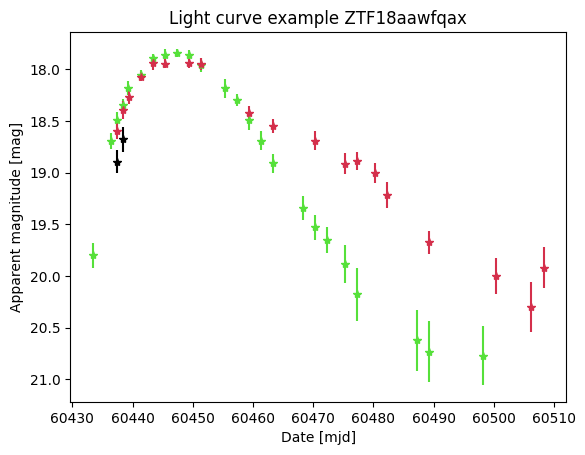

In [25]:
plot_light_curve(light_curve, title=f'Light curve example {oid}')

### Query the ALeRCE DB for features

The ALeRCE database (ADB) contains  over 170 features calculated for each object. We will directly query the ADB and get those features out. We start by downloading the credentials file and connecting to the ADB.

In [26]:
!wget https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
credentials_file = "alercereaduser_v4.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
conn = psycopg2.connect(
    dbname=params['dbname'], 
    user=params['user'], 
    host=params['host'], 
    password=params['password'])

--2024-08-03 09:02:26--  https://github.com/alercebroker/usecases/raw/master/alercereaduser_v4.json
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json [following]
--2024-08-03 09:02:31--  https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: ‘alercereaduser_v4.json’

alercereaduser_v4.j 100%[===================>]     156  --.-KB/s    in 0s      

2024-08-03 09:02:35 (3.38 MB/s) - ‘alercereaduser_v4.json’ saved [156/156]



As an example, we will use the object with object id (oid) 'ZTF19acelhxy' which can be found in the ALeRCE explorer: https://alerce.online/object/ZTF19acelhxy.

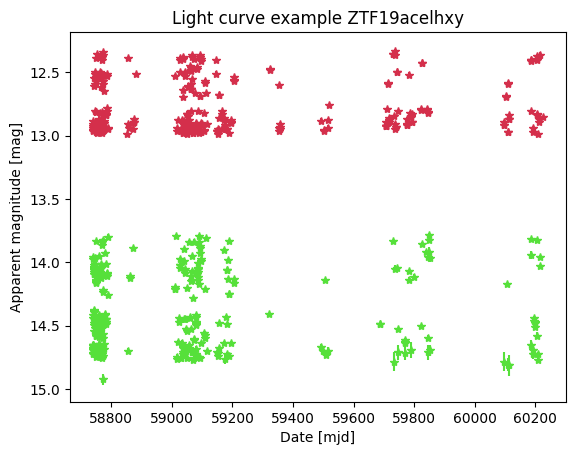

In [27]:
oid = "ZTF19acelhxy"
light_curve = alerce_client.query_detections(oid, format='pandas')
plot_light_curve(light_curve, title=f'Light curve example {oid}', apparent = True)

Query the ALeRCE DB for all the features for that particular object

In [28]:
query = "select * from feature where oid='" + str(oid) + "';"
object_feat = pd.read_sql_query(query, conn)

In [29]:
display(object_feat)

,oid,name,value,fid,version
0,ZTF19acelhxy,iqr,0.591698,1,lc_classifier_1.2.1-P
1,ZTF19acelhxy,iqr,0.349977,2,lc_classifier_1.2.1-P
2,ZTF19acelhxy,Amplitude,0.465350,1,lc_classifier_1.2.1-P
3,ZTF19acelhxy,AndersonDarling,1.000000,1,lc_classifier_1.2.1-P
4,ZTF19acelhxy,Autocor_length,1.000000,1,lc_classifier_1.2.1-P
...,...,...,...,...,...
349,ZTF19acelhxy,SPM_tau_rise,63.494134,1,lc_classifier_1.2.1-P-transitional
350,ZTF19acelhxy,SPM_tau_fall,54.805040,1,lc_classifier_1.2.1-P-transitional
351,ZTF19acelhxy,SPM_chi,789.809391,1,lc_classifier_1.2.1-P-transitional
352,ZTF19acelhxy,SPM_A,19.594852,2,lc_classifier_1.2.1-P-transitional


As an example of the use of features, we will use the period to fold the light curve.

In [30]:
period = object_feat[object_feat['name'] == "Multiband_period"]['value'].values[0]

In [31]:
print (period)

3.799999864101415


Now, we fold and plot the light curve.

(640,) (640,) (640,)
(582,) (582,) (582,)


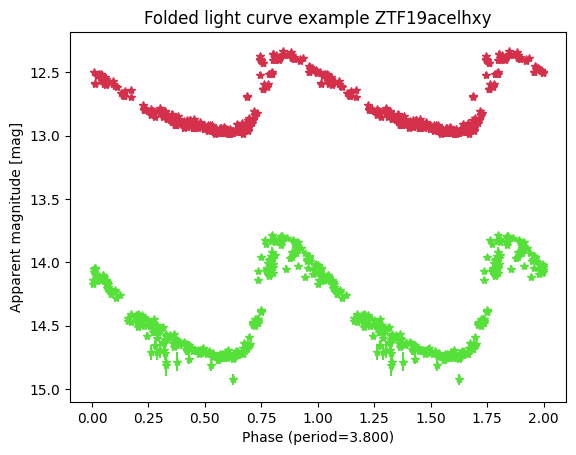

In [32]:
plot_light_curve(light_curve, title=f'Folded light curve example {oid}', period = period, apparent = True)

## Using the features release

ALeRCE has also released all features calculated for objects up to May 3rd, 2024. They can be downloaded as a parquet file here: https://doi.org/10.5281/zenodo.11123894.

In this part of the tutorial, we will:
* load the parquet features release
* search for objects in the ALeRCE DB and download their features
* select similar objects to the ones selected in terms of their features

In [35]:
dict_info = {
#    'oid_object': ['ZTF18aawfqax','ZTF21aaqqwsa'], #['ZTF22aadpscu'], # ['ZTF18abgpzts'],  #['ZTF23aaxuvkn'], # ,# ['ZTF21aanfcmk'] # Busqueda de un objeto a la vez
#    'data_file': 'features.parquet',
#    'k_nn': 5000,  # 200,
}


### Load features release data

In [36]:
release_filename = 'features.parquet'
data = pd.read_parquet(release_filename).set_index('oid')
display(data)

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,
ZTF22aabgrek,NaN,0.033651,NaN,0.809992,NaN,1.0,NaN,0.333333,NaN,0.0,...,0.0,0.0,1.0,6.0,1.000000,1.000000,2.776421,3.666420,0.790000,0.979869
ZTF18abumkut,NaN,0.035398,NaN,0.616626,NaN,1.0,NaN,0.250000,NaN,0.0,...,8.0,12.0,2.0,8.0,1.000000,1.000000,4.684831,7.393831,0.839286,0.993542
ZTF19abcejaa,0.567169,0.183057,1.000000,1.000000,5.0,2.0,0.175000,0.344828,0.000000,0.0,...,0.0,0.0,6.0,1.0,0.150000,0.034483,5.297417,8.109416,0.945714,0.803289
ZTF18acjvvot,0.061632,0.033853,0.687478,0.778749,1.0,2.0,0.357143,0.372093,0.000000,0.0,...,2.0,68.0,70.0,43.0,1.000000,1.000000,2.777639,3.667638,0.855714,0.979869
ZTF21aacomkz,0.053794,0.032420,0.363219,0.967365,1.0,2.0,0.300000,0.347826,0.000000,0.0,...,0.0,24.0,10.0,23.0,1.000000,1.000000,2.769856,3.659855,0.870000,0.979869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18accboxe,0.223578,0.412897,1.000000,1.000000,3.0,1.0,0.225000,0.176471,0.078947,0.0,...,0.0,3.0,33.0,15.0,0.825000,0.882353,5.048504,7.552504,0.816667,0.116780
ZTF18abvzlln,0.130467,0.116905,0.627308,0.748061,1.0,2.0,0.280000,0.266667,0.000000,0.0,...,8.0,11.0,25.0,15.0,1.000000,1.000000,5.425498,8.027498,0.623571,0.199893
ZTF18abhueor,0.279524,0.218180,0.999624,1.000000,1.0,1.0,0.333333,0.160714,0.000000,0.0,...,16.0,1.0,2.0,3.0,0.222222,0.053571,3.049909,5.577909,0.825714,1.000000


### Search objects in the ALeRCE DB


In [37]:
oids = ['ZTF18aawfqax']

conn = psycopg2.connect(
        dbname=params['dbname'], 
        user=params['user'], 
        host=params['host'], 
        password=params['password'])

base_query = """SELECT oid, CONCAT(name, '_', fid) AS feature, value
FROM feature  
WHERE oid IN (%s)"""

batch = [f"'{o}'" for o in oids]
batch = ",".join(batch)
query = base_query % batch
df_features_q = pd.read_sql(query, conn)

df_features_q = df_features_q.pivot_table(values='value', index="oid", columns='feature', aggfunc='first')

In [38]:
display(df_features_q)

feature,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aawfqax,0.707719,0.451899,0.978339,0.61371,5.0,4.0,0.304348,0.4375,0.0,0.0,...,3.0,6.0,8.0,7.0,23.0,16.0,1.0,1.0,0.957143,0.046583


## Unified dataset 

In [40]:
for i in df_features_q.index:
    if i in data.index:
        data.drop([i], axis=0, inplace=True)

data = pd.concat([data, df_features_q])

df_objs = data[[]].copy()
df_objs['url'] = ['https://alerce.online/object/{}'.format(oid) for oid in df_objs.index.unique()]
df_objs['query'] = 0
df_objs.loc[df_features_q.index[0], 'query'] = 1
df_objs = df_objs[['url', 'query']]
df_objs

,url,query
oid,,
ZTF22aabgrek,https://alerce.online/object/ZTF22aabgrek,0
ZTF18abumkut,https://alerce.online/object/ZTF18abumkut,0
ZTF19abcejaa,https://alerce.online/object/ZTF19abcejaa,0
ZTF18acjvvot,https://alerce.online/object/ZTF18acjvvot,0
ZTF21aacomkz,https://alerce.online/object/ZTF21aacomkz,0
...,...,...
ZTF18abvzlln,https://alerce.online/object/ZTF18abvzlln,0
ZTF18abhueor,https://alerce.online/object/ZTF18abhueor,0
ZTF18abvpvhy,https://alerce.online/object/ZTF18abvpvhy,0


In [41]:
df_objs.groupby('query').count()

,url
query,
0,2188495
1,1


## Normalize dataset

In [42]:
data_qt = data.copy()
qt = QuantileTransformer(n_quantiles=10, output_distribution='uniform', random_state=0)

for column in data_qt.columns:
    non_nan_data = data_qt[column].dropna().values.reshape(-1, 1)
    transformed_non_nan_data = qt.fit_transform(non_nan_data) * 0.9 + 0.1
    data_qt.loc[data_qt[column].notna(), column] = transformed_non_nan_data.flatten()

data_qt = data_qt.fillna(0)
data_qt

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,
ZTF22aabgrek,0.000000,0.200979,0.000000,0.429136,0.000,0.100000,0.000000,0.600000,0.0,0.1,...,0.100000,0.100000,0.500000,0.600000,1.000000,1.000000,0.493566,0.382469,0.628799,0.514093
ZTF18abumkut,0.000000,0.210754,0.000000,0.330477,0.000,0.100000,0.000000,0.350000,0.0,0.1,...,0.666667,0.660000,0.533333,0.666667,1.000000,1.000000,0.714187,0.796689,0.787407,0.712754
ZTF19abcejaa,0.903665,0.666857,0.900000,0.899997,0.904,0.800000,0.215000,0.658621,0.1,0.1,...,0.100000,0.100000,0.650000,0.450000,0.476500,0.417241,0.773541,0.865118,0.965217,0.275674
ZTF18acjvvot,0.308493,0.202110,0.333092,0.410361,0.100,0.800000,0.704631,0.753807,0.1,0.1,...,0.400000,0.900950,0.906706,0.901677,1.000000,1.000000,0.493848,0.382681,0.832500,0.514093
ZTF21aacomkz,0.278599,0.196419,0.190245,0.560396,0.100,0.800000,0.500000,0.673913,0.1,0.1,...,0.100000,0.800000,0.725000,0.840000,1.000000,1.000000,0.492045,0.381325,0.870000,0.514093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18abvzlln,0.496646,0.512409,0.304987,0.393547,0.100,0.800000,0.435000,0.386667,0.1,0.1,...,0.666667,0.640000,0.845000,0.800000,1.000000,1.000000,0.785951,0.857130,0.166935,0.199970
ZTF18abhueor,0.762684,0.727957,0.666899,1.000000,0.100,0.100000,0.600000,0.196210,0.1,0.1,...,0.807692,0.300000,0.533333,0.525000,0.511245,0.426786,0.539683,0.657941,0.745185,1.000000
ZTF18abvpvhy,0.147618,0.172190,0.172432,0.330770,0.100,0.100000,0.600000,0.200000,0.1,0.1,...,0.901722,0.901096,0.100000,0.100000,0.100000,0.100000,0.394748,0.324657,0.390698,0.459921


## Similarity search

Now we search for the K nearest neighbours to the query objects.

In [44]:
dim = data_qt.shape[1]
index = faiss.IndexFlatL2(dim) 
index.add(data_qt)

k = 200
xq = data_qt.filter(items=[df_features_q.index[0]], axis=0)
D, I = index.search(xq, k)

In [45]:
I.shape

(1, 200)

In [46]:
def print_link(index=None, classifier=None):
    expr1 = 'https://alerce.online/?oid='
    expr2 = '&oid='.join(list(index))
    expr3 = '&selectedClassifier=' + classifier + '_classifier&page=1'
    expr = expr1 + expr2 + expr3

    display(HTML("<a href='%s' target=\"_blank\"> %s <a>" % (expr, expr)))
    
print('Link of the closest objects:')
print_link(index=data_qt.index.values[I[0][0:199]], classifier="stamp")

Link of the closest objects:


In [47]:
df_data_knn = data_qt.iloc[I[0]]
df_data_knn

,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aawfqax,0.908261,0.902689,0.530041,0.329078,0.904,0.901389,0.513043,0.900391,0.1,0.1,...,0.666667,0.533333,0.835000,0.805000,1.0,1.0,0.0,0.0,0.976812,0.199955
ZTF21aazqkeq,0.919537,0.911847,0.274664,0.404877,0.904,0.904167,0.675000,0.665385,0.1,0.1,...,0.633333,0.566667,0.820000,0.855000,1.0,1.0,0.0,0.0,0.951449,0.199955
ZTF23absguth,0.932578,0.930349,0.795825,0.382200,0.902,0.900000,0.427778,0.447619,0.1,0.1,...,0.450000,0.400000,0.810000,0.783333,1.0,1.0,0.0,0.0,0.416667,0.200000
ZTF24aabsfyt,0.910241,0.901939,0.362372,0.397059,0.800,0.900000,0.359091,0.225000,0.1,0.1,...,0.750000,0.466667,0.700000,0.733333,1.0,1.0,0.0,0.0,0.955072,0.200000
ZTF24aagiouv,0.917433,0.921351,0.451633,0.139642,0.800,0.900000,0.300000,0.730048,0.1,0.1,...,0.633333,0.620000,0.712500,0.733333,1.0,1.0,0.0,0.0,0.951449,0.199953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aasfhia,0.916834,0.901470,0.196256,0.253769,0.900,0.900000,0.723576,0.858818,0.1,0.1,...,0.750000,0.680000,0.737500,0.750000,1.0,1.0,0.0,0.0,0.813750,0.199956
ZTF20abgxuqt,0.935560,0.968189,0.429174,0.570273,0.908,0.901389,0.537500,0.328000,0.1,0.1,...,0.900717,0.803226,0.902367,0.903145,1.0,1.0,0.0,0.0,0.942029,0.447482
ZTF21aaqzqaa,0.915332,0.928899,0.605334,0.619750,0.900,0.901389,0.359091,0.323810,0.1,0.1,...,0.700000,0.433333,0.750000,0.830000,1.0,1.0,0.0,0.0,0.955072,0.310546


### Visualizing K nearest neighbours

We use tensorboard to visualize the objects in a reduced-dimensionality space.

In [48]:
%load_ext tensorboard

In [49]:
df_objs_knn = df_objs.reindex(df_data_knn.index)
df_objs_knn

,url,query
oid,,
ZTF18aawfqax,https://alerce.online/object/ZTF18aawfqax,1
ZTF21aazqkeq,https://alerce.online/object/ZTF21aazqkeq,0
ZTF23absguth,https://alerce.online/object/ZTF23absguth,0
ZTF24aabsfyt,https://alerce.online/object/ZTF24aabsfyt,0
ZTF24aagiouv,https://alerce.online/object/ZTF24aagiouv,0
...,...,...
ZTF20aasfhia,https://alerce.online/object/ZTF20aasfhia,0
ZTF20abgxuqt,https://alerce.online/object/ZTF20abgxuqt,0
ZTF21aaqzqaa,https://alerce.online/object/ZTF21aaqzqaa,0


In [51]:
log_dir = 'logs'
#data_name = 'ZTF_dataset'

dict_metadata = {
    'oid': list(df_objs_knn.index),
    'url': list(df_objs_knn['url'].values),
    'outlier': list(df_objs_knn['query'].values)
    # Agrega aquí más columnas si necesitas
}

In [52]:
metadata_file_path = f'{log_dir}/metadata.tsv'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Escribir los datos en el archivo .tsv
with open(metadata_file_path, 'w') as file:
    column_names = '\t'.join(dict_metadata.keys())
    file.write(column_names + '\n')

    num_rows = len(next(iter(dict_metadata.values())))

    for i in range(num_rows):
        row_data = [str(dict_metadata[column][i]) for column in dict_metadata]
        file.write('\t'.join(row_data) + '\n')


# Crear un checkpoint desde los datos
weights = tf.Variable(df_data_knn)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint_prefix = os.path.join(log_dir, "embedding.ckpt")
checkpoint.save(checkpoint_prefix)

'logs/embedding.ckpt-1'

In [53]:
# Inicializa un proyector
config = projector.ProjectorConfig()
embedding_config = config.embeddings.add()

# Especifica los nombres de los tensors y la ruta a los metadatos
embedding_config.tensor_name = f"embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding_config.metadata_path = 'metadata.tsv'

# Guarda una proyección configurada
projector.visualize_embeddings(log_dir, config)

In [54]:
#%tensorboard --logdir ./logs --host 0.0.0.0

In [ ]:
#!kill 4013354